In [1]:
!pip install git+https://github.com/jeanollion/dataset_iterator.git
import tensorflow as tf
import h5py
import numpy as np
import matplotlib.pyplot as plt

dataset_path = "/home/cifar10.h5"
def save_cifar():
  (train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()
  out_file= h5py.File(dataset_path, 'w')
  out_file.create_dataset("cifar10/train/images", data = train_images)
  out_file.create_dataset("cifar10/train/labels", data = train_labels)
  out_file.create_dataset("cifar10/eval/images", data = test_images)
  out_file.create_dataset("cifar10/eval/labels", data = test_images)
  out_file.close()
save_cifar()

def plot_images(batch_x, batch_y, n=3):
  plt.figure(figsize=(n*3, 6))
  for i in range(n):
    plt.subplot(2, n, i+1)
    plt.imshow(np.clip(batch_x[i], 0, 1))
    plt.title(label='X')
    plt.axis("off")
    plt.subplot(2, n, n+i+1)
    plt.imshow(np.clip(batch_y[i], 0, 1))
    plt.title(label='Y')
    plt.axis("off")

  Cloning https://github.com/jeanollion/dataset_iterator.git to /tmp/pip-req-build-vnj59wkj
  Running command git clone -q https://github.com/jeanollion/dataset_iterator.git /tmp/pip-req-build-vnj59wkj
  Created wheel for dataset-iterator: filename=dataset_iterator-0.0.1-cp36-none-any.whl size=35945 sha256=c10b10eac25d8926461c863a07d61f9ccccd1ef7855443969137c435c27991a1
  Stored in directory: /tmp/pip-ephem-wheel-cache-rfw13yuo/wheels/e1/b1/4a/efb8888afaa53e058db8520c203e13af93ca10b2a8d42ab098
Successfully built dataset-iterator
170500096/170498071 [==============================] - 2s 0us/step


# Simple Datagenerator that return the same input / output

In [2]:
from dataset_iterator import MultiChannelIterator, PreProcessingImageGenerator
image_scaling = PreProcessingImageGenerator(lambda im:im/255.) # simple scaling of 8-bit images -> data in [0, 1]

iterator = MultiChannelIterator(dataset = dataset_path, 
                                channel_keywords=["/images", "/labels"], # in this case there is one channel. "/images" is a keyword allowing to distinguish 
                                group_keyword = "train", # change this for "eval" to get only evaluation dataset
                                input_channels=[0],
                                output_channels=[0], 
                                image_data_generators= [image_scaling, None],
                                batch_size=64
                                )

In [3]:
batch_x, batch_y = iterator[0]
print("batch shape: {}, number of batches: {}, maximal value: {}".format(batch_x.shape, len(iterator), batch_x.max()))

batch shape: (64, 32, 32, 3), number of batches: 782, maximal value: 1.0


## Train / Test split

In [4]:
train_it, test_it = iterator.train_test_split(test_size = 0.2)
print("number of train batches: {} / test batches: {}".format(len(train_it), len(test_it)))

number of train batches: 625 / test batches: 157


## Restrict to a subset of indices
Restriction to images belonging to one class. Train/Test split must be executed after set_allowed_indexes. 

In [ ]:
from dataset_iterator.helpers import open_channel
train_labels = open_channel(dataset = dataset_path, channel_keyword = "/labels", group_keyword = "train")
iterator.set_allowed_indexes(np.where(train_labels==0)[0])
print("number of batches of class 0: {}".format(len(iterator)))

# Iterator with data augmentation
- input images: geometrical transformations + corruption
- output images: same geometrical transformations (no corruption)

In [ ]:
from dataset_iterator import MultiChannelIterator
#from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

corruption_function = lambda im : im + np.random.normal(0, 10, im.shape) # define here a corruption function that input a singla image and return and image of same shape
data_gen_in = ImageDataGenerator(vertical_flip = True,
                                 height_shift_range = 0.5,
                                 rescale = 1./255, # to have values in range [0, 1]
                                 fill_mode="nearest",
                                 preprocessing_function = corruption_function)
data_gen_out = ImageDataGenerator(rescale = 1./255,
                                  fill_mode="nearest",
                                  ) # no need to define geometrical transformations in this generator, as those of data_gen_in will automatically be applied, using the current fill_mode

iterator = MultiChannelIterator(dataset = dataset_path, 
                                channel_keywords=["/images", "/images"], # for clarity we open here twice the images as they will be processed differently. one can also set None instead of the second keyword (as a placeholder) and define the corruption process in the channel_postprocessing_function argument.
                                group_keyword = "train", # change this for "eval" to get only evaluation dataset
                                input_channels=[0],
                                output_channels=[1], 
                                image_data_generators= [data_gen_in, data_gen_out], # one data generator for each channel (as defined in channel_keywords). Geometrical transformations will be identical
                                batch_size=64
                                )

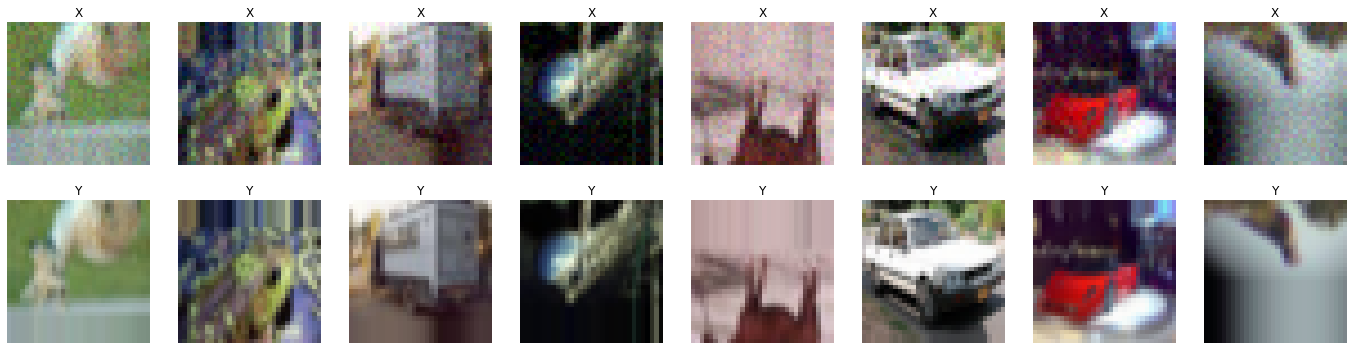

In [ ]:
batch_x, batch_y = iterator[0]
plot_images(batch_x, batch_y, 8)

# More complex/flexible processing
It is also possible to define a postprocessing function that has access to all open channels. In the following example we will achieve the same as the previous example using a postprocessing function 

In [ ]:
from dataset_iterator import MultiChannelIterator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

corruption_function = lambda im : im + np.random.normal(0, 10./255, im.shape) # define here a corruption function that input a singla image and return and image of same shape
data_gen_in = ImageDataGenerator(vertical_flip = True,
                                 height_shift_range = 0.5,
                                 rescale = 1./255, # to have values in range [0, 1]
                                 fill_mode="nearest")
def channels_postprocessing_function(batch_by_channel):
  batch_by_channel[1] = np.copy(batch_by_channel[0])
  batch_by_channel[0] = corruption_function(batch_by_channel[0])

iterator = MultiChannelIterator(dataset = dataset_path, 
                                channel_keywords=["/images", None], # the second channel is set as None, as a placeholder that will be filled by the channels_postprocessing_function
                                group_keyword = "train", 
                                input_channels=[0],
                                output_channels=[1], 
                                image_data_generators= [data_gen_in, None], 
                                channels_postprocessing_function=channels_postprocessing_function,
                                batch_size=64
                                )

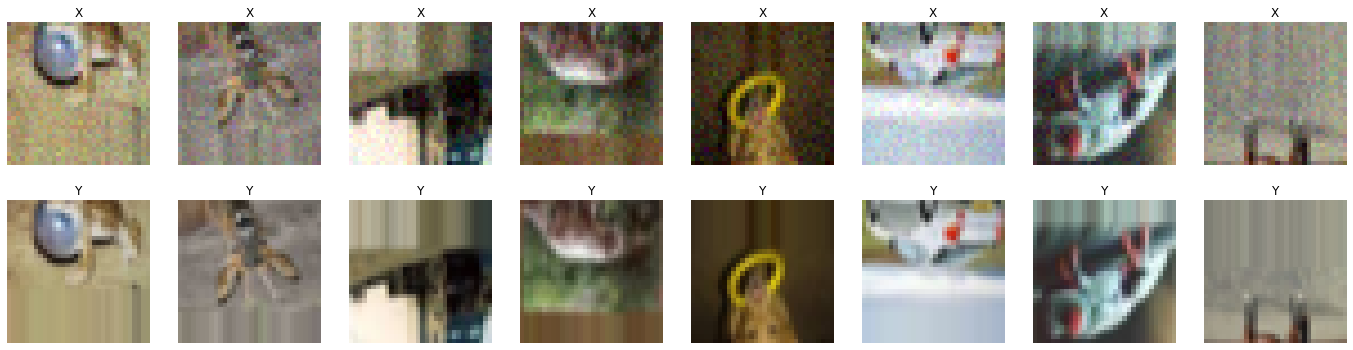

In [ ]:
batch_x, batch_y = iterator[0]
plot_images(batch_x, batch_y, 8)

# Tilling

In [ ]:
from dataset_iterator import MultiChannelIterator
from dataset_iterator.tile_utils import extract_tile_function

scaling_function = lambda im:im/255.
tile_function = extract_tile_function(tile_shape=(16, 16), perform_augmentation=True, random_stride=True, scaling_function=scaling_function)
iterator = MultiChannelIterator(dataset = dataset_path, 
                                channel_keywords=["/images"],
                                group_keyword = "train",
                                input_channels=[0],
                                output_channels=[0], 
                                extract_tile_function=tile_function,
                                batch_size=64
                                )

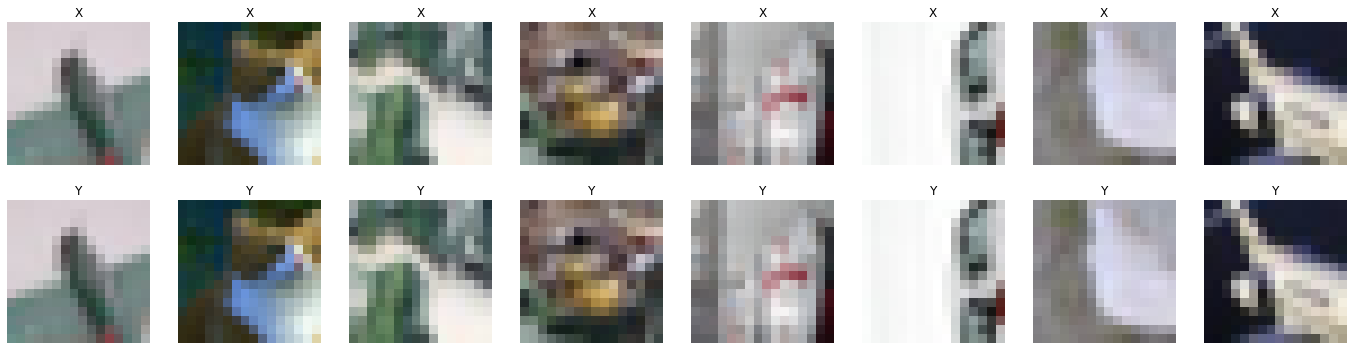

In [ ]:
batch_x, batch_y = iterator[0]
plot_images(batch_x, batch_y, 8)

# Group Mixture

In the following cells we will show how to generate batches with different proportions of images from different groups.
We first split groups in the .h5 dataset file.

In [ ]:
dataset_path_class = "/home/cifar10_class.h5"

def save_cifar_by_class():
  (train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()
  out_file= h5py.File(dataset_path_class, 'w')
  for c in range(10):
    out_file.create_dataset("cifar10/train/{}/images".format(c), data = train_images[train_labels.squeeze(-1)==c])
    out_file.create_dataset("cifar10/eval/{}/images".format(c), data = test_images[test_labels.squeeze(-1)==c])
  out_file.close()
save_cifar_by_class()

In [ ]:
scaling_function = lambda im:im/255.
iterator = MultiChannelIterator(dataset = dataset_path_class, 
                                channel_keywords=["/images"], 
                                group_keyword = "train", # all classes will be concatenated
                                input_channels=[0],
                                output_channels=[0], 
                                image_data_generators= [image_scaling],
                                batch_size=64
                                )
print("number of batches for all classes: {}".format(len(iterator)))

number of batches for all classes: 782


In [ ]:
iterator = MultiChannelIterator(dataset = dataset_path_class, 
                                channel_keywords=["/images"], 
                                group_keyword = "train/0/", # only class 0 will be concatenated
                                input_channels=[0],
                                output_channels=[0], 
                                image_data_generators= [image_scaling],
                                batch_size=64
                                )
print("number of batches for class 0: {}".format(len(iterator)))

number of batches for class 0: 79


In [ ]:
iterator = MultiChannelIterator(dataset = dataset_path_class, 
                                channel_keywords=["/images"], 
                                group_keyword = ["train/{}/".format(c) for c in range(10)],
                                input_channels=[0],
                                output_channels=[0], 
                                image_data_generators= [image_scaling],
                                batch_size=64
                                )
print("number of batches for all classes : {}".format(len(iterator)))

number of batches for all classes : 782


in each batch we want an average of 60% airplanes (class 0) and 40% cars (class 1)

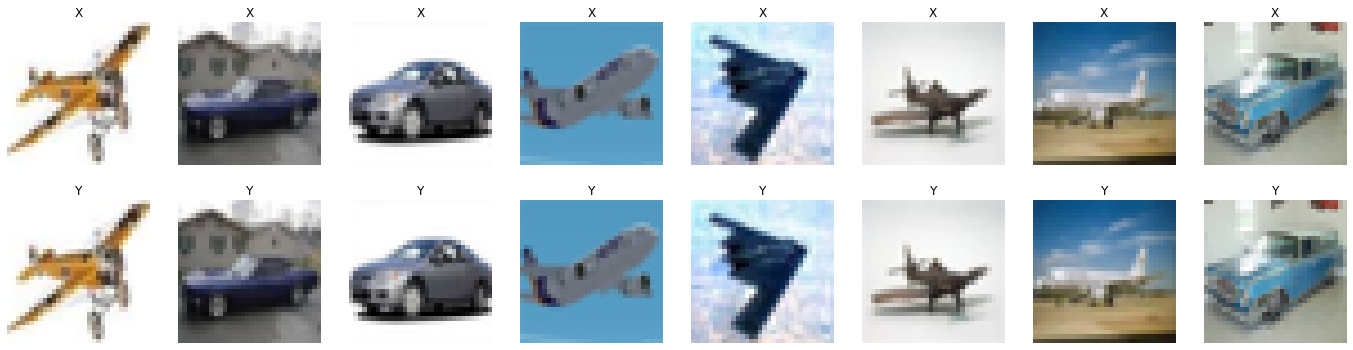

In [ ]:
iterator.group_proportion = [0.6, 0.4, 0, 0, 0, 0, 0, 0, 0, 0]
batch_x, batch_y = iterator[0]
plot_images(batch_x, batch_y, 8)